In [64]:
# Import necessary modules and functions

import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import datetime
import math

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

kaggledf = pd.read_csv('KS_train_data.csv', delimiter = ',')

In [2]:
train_purpose = ["pledged","funded"]
test_columns = ["project_id", "blurb", "category", "country", "created_at", "currency", "deadline", "fx_rate", "goal", "launched_at", "name", "staff_pick", "location", "subcategory", "project_url"]

test_columns += train_purpose

#drop colums that are not in test_set + reward URL
kaggledf = kaggledf.drop(columns=[col for col in kaggledf if col not in test_columns])

In [3]:
#calculate seconds from UNIX timestamp
kaggledf["seconds"] = kaggledf["deadline"] - kaggledf["created_at"]

In [4]:
#log transform time columns
time_cols = ["seconds","deadline","created_at","launched_at"]
for col in time_cols:
    kaggledf[col] = np.log(kaggledf[col])

In [5]:
#convert all goals to USD    
kaggledf["goal"] = kaggledf["goal"] * kaggledf["fx_rate"]
if "pledged" in kaggledf.columns:
    kaggledf["pledged"] = kaggledf["pledged"] * kaggledf["fx_rate"]

#delete unnessesary colums

kaggledf = kaggledf.drop(columns=["fx_rate", "currency"])

In [6]:
#strip url of unnessesary stuff
def stripper(x): #XD
    raw = x.split("/")[-1].split("-")
    return " ".join(raw)

kaggledf["project_url"] = kaggledf["project_url"].apply(lambda x: stripper(x))

#delete original url column
kaggledf = kaggledf.drop(columns = ["name"])

In [7]:
#categorical to numerical data

dummy_category = pd.get_dummies(kaggledf['category'], prefix = "category_")
#dummy_subcategory = pd.get_dummies(kaggledf['subcategory'], prefix = "subcategory_")
#dummy_country = pd.get_dummies(kaggledf['country'], prefix = "country_")
kaggledf = pd.merge(left=kaggledf, right=dummy_category,left_index=True,right_index=True)
#kaggledf = pd.merge(left=kaggledf, right=dummy_subcategory,left_index=True,right_index=True)
#kaggledf = pd.merge(left=kaggledf, right=dummy_country,left_index=True,right_index=True)


    
kaggledf = kaggledf.drop(columns = ["category","subcategory","country"])

In [8]:
#cange staffpick to numerical
kaggledf["staff_pick"] = kaggledf["staff_pick"].apply(lambda x: 1 if x == True else 0)

#change funded to numerical if in df
if "funded" in kaggledf.columns: 
    kaggledf["funded"] = kaggledf["funded"].apply(lambda x: 1 if x == True else 0)

In [9]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)
#categorical ranges for goal and pledged, sentiment vader (numerical & categorical)  
#columns to be removed: url's, location, id,
kaggledf.dropna(inplace=True)

kaggledf

,project_id,blurb,created_at,deadline,goal,launched_at,pledged,staff_pick,location,funded,project_url,seconds,category__art,category__comics,category__crafts,category__dance,category__design,category__fashion,category__film & video,category__food,category__games,category__journalism,category__music,category__photography,category__publishing,category__technology,category__theater
0,KS_000000,I will be an artist-in-residence at Elsewhere ...,21.005418,21.012097,2800.000000,21.010675,3596.000000,0,"Paonia, CO",1,elsewhere studios artist in residency program,15.999994,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,KS_000001,1000 Artists is a public art-making installati...,21.009141,21.013275,4500.000000,21.010686,4586.000000,0,"Washington, DC",1,1000 artists presidential inauguration 2013,15.522812,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,KS_000002,"The Sequel to ‘My Favorite Machine”, ""MyPhoneH...",21.010235,21.014573,5000.000000,21.010692,5217.000000,0,"Frisco, TX",1,myphonehenge,15.572134,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,KS_000003,A film exploring the role and value of art edu...,21.010204,21.012052,6500.000000,21.010692,7160.000000,0,"Glasgow, UK",1,walk through,14.717153,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,KS_000004,We need to build a kitchen for Habitable Space...,21.007363,21.012635,15000.000000,21.010692,15445.000000,0,"Kingsbury, TX",1,a kitchen for habitable spaces,15.764505,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,KS_099995,Make the workshop/ small stage space at Jimmy'...,21.022391,21.028212,7000.000000,21.026300,7595.430000,0,"New York, NY",1,help fund the back room arts space at jimmys n...,15.879122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
99996,KS_099996,Help create a permanent home for live comedy s...,21.034376,21.036377,25000.000000,21.034480,27196.710000,0,"Richmond, VA",1,the coalition theater 0,14.821609,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
99997,KS_099997,Voix de Ville is a pop-up imaginarium of neo-v...,21.035210,21.040802,5500.000000,21.038491,7226.000000,1,"Cleveland, OH",1,the voix de ville a pop up theater and cabaret,15.851484,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
99998,KS_099998,Help Synetic Theater create a new Studio to pr...,21.039664,21.042922,25000.000000,21.040678,31683.000000,0,"Arlington, VA",1,save the studio,15.314540,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


# Data Exploration

<AxesSubplot:>

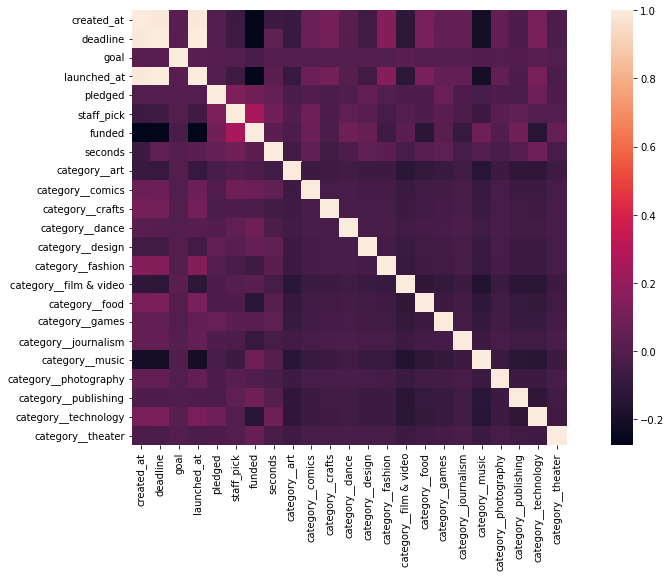

In [231]:
corr_cols = ["created_at","pledged","staff_pick","funded","seconds","goal","category__art","category__comics","category__crafts","category__dance","category__design","category__fashion","category__film & video","category__food","category__games","category__journalism","category__music","category__photography","category__publishing","category__technology","category__theater"]

corrmat = kaggledf.corr()
sns.heatmap(corrmat, square=True, annot=False)

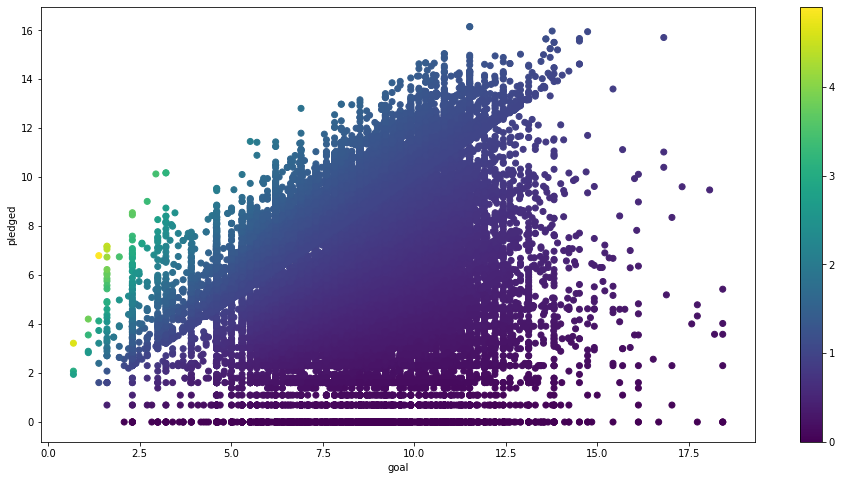

In [70]:
plt.figure()

goal = np.log(kaggledf["goal"].astype(int))
pledged = np.log(kaggledf["pledged"].astype(int))
c = pledged/goal

for i,num in enumerate(c):
    if num == math.inf or num > 12:
        c.pop(i)
        pledged.pop(i)
        goal.pop(i)

plt.scatter(goal, pledged, c = c)
plt.xlabel("goal")
plt.ylabel("pledged")
plt.colorbar()